In [1]:
import os

from IPython.core.pylabtools import figsize

root_dir = "Data/CAPTCHA Images/samples"

images_path = []
labels = []

for image_name in os.listdir(root_dir):
    if not image_name.endswith(".png"):
        continue
    label = os.path.splitext(image_name)[0]

    images_path.append(image_name)
    labels.append(label)

for image_name in os.listdir(os.path.join(root_dir, 'samples')):
    if not image_name.endswith(".png"):
        continue
    label = os.path.splitext(image_name)[0]

    images_path.append(os.path.join("samples", image_name))
    labels.append(label)

print(len(images_path))


2080


In [2]:
print(images_path[0])

226md.png


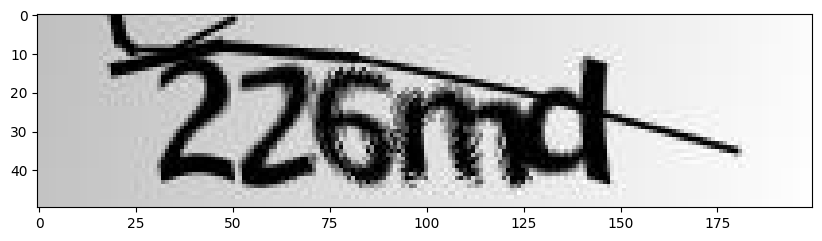

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = os.path.join(root_dir, images_path[0])

image = Image.open(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [4]:
import string

characters = string.digits + string.ascii_lowercase  # '0123456789abcdefghijklmnopqrstuvwxyz'
num_classes = len(characters)  # = 36
print("Classes count: ", num_classes)

Classes count:  36


In [5]:
char_to_index = {char: idx for idx, char in enumerate(characters)}
index_to_char = {idx: char for char, idx in char_to_index.items()}  # برای نمایش مجدد

In [6]:
# ورودی: ['4g7p', '3t9k', '1z8m']
# خروجی: [[4, 16, 7, 25], [3, 29, 9, 20], [1, 35, 8, 22]]

label_indices = [[char_to_index[char] for char in label] for label in labels]

In [7]:
from tensorflow.keras.utils import to_categorical
import numpy as np

label_indices = np.array(label_indices)  # shape: (batch, seq_len)
print(label_indices.shape)

# حالا جدا جدا هر ستون (کاراکتر اول، دوم، سوم، چهارم) رو one-hot می‌کنیم:
y_chars = []

seq_len = label_indices.shape[1]  # مثلا 4
for i in range(seq_len):
    y_char_i = to_categorical(label_indices[:, i], num_classes=num_classes)  # shape: (batch, 36)
    y_chars.append(y_char_i)

y_chars = np.array(y_chars)
print(y_chars.shape)

(2080, 5)
(5, 2080, 36)


In [8]:
y_chars = np.transpose(y_chars, (1, 0, 2))
print(y_chars.shape)

(2080, 5, 36)


In [9]:
from sklearn.model_selection import train_test_split

train_path, test_path, train_labels, test_labels = train_test_split(images_path, y_chars, test_size=0.2, random_state=42)

In [10]:
train_labels = [train_labels[:, i, :] for i in range(5)]
test_labels = [test_labels[:, i, :] for i in range(5)]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(5, 1664, 36)
(5, 416, 36)


In [11]:
import tensorflow as tf
import numpy as np

def create_tf_dataset(images_path, labels):
    def generator():
        for idx in range(len(images_path)):
            image = Image.open(os.path.join(root_dir, images_path[idx]))
            if image.mode == 'RGBA':
                image = image.convert('RGB')

            label = labels[:, idx, :]
            label_dict = {f'char_{i+1}': label[i] for i in range(5)} # 5 because of seq length

            yield image, label_dict

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            {
                f'char_{i+1}': tf.TensorSpec(shape=(36,), dtype=tf.int32) for i in range(5)
            }
        )
    )

train_dataset = create_tf_dataset(train_path, train_labels)
test_dataset = create_tf_dataset(test_path, test_labels)

In [12]:
def preprocess(image, label):
    image = tf.image.resize(image, size=(200, 50))

    image = tf.cast(image, dtype=tf.float32) / 255.0

    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [13]:
sample_img, sample_label = next(iter(train_dataset))
print(sample_img.shape)

(200, 50, 3)


In [15]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

num_classes = 36  # A-Z + a-z + 0-9  (یا فقط 10 برای 0-9)
seq_length = 5    # تعداد کاراکترهای کپچا (ثابت فرض می‌کنیم)

input_shape=(200, 50, 3)
inputs = Input(shape=input_shape)
base_model = EfficientNetB0(include_top=False, input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)

outputs = [Dense(num_classes, activation='softmax', name=f'char_{i+1}')(x) for i in range(seq_length)]

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] * 5)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 50,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 200, 50,   │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 200, 50,   │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 200, 50,   │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 201, 51,   │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 100, 25,   │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 100, 25,   │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 100, 25,   │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 100, 25,   │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 100, 25,   │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 100, 25,   │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 100, 25,   │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 100, 25,   │        512 │ block1a_se_excit

 Total params: 4,280,151 (16.33 MB)

 Trainable params: 4,238,128 (16.17 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [17]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Optimizing datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = len(train_path) // BATCH_SIZE
validation_steps = len(test_path) // BATCH_SIZE

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [21]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 607ms/step - char_1_accuracy: 0.9999 - char_1_loss: 0.0064 - char_2_accuracy: 1.0000 - char_2_loss: 0.0086 - char_3_accuracy: 0.9999 - char_3_loss: 0.0106 - char_4_accuracy: 0.9999 - char_4_loss: 0.0097 - char_5_accuracy: 1.0000 - char_5_loss: 0.0076 - loss: 0.0430 - val_char_1_accuracy: 0.7043 - val_char_1_loss: 0.8702 - val_char_2_accuracy: 0.7572 - val_char_2_loss: 0.8226 - val_char_3_accuracy: 0.6394 - val_char_3_loss: 1.2419 - val_char_4_accuracy: 0.6010 - val_char_4_loss: 1.4645 - val_char_5_accuracy: 0.6274 - val_char_5_loss: 1.2855 - val_loss: 5.6847 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 65s 626ms/step - char_1_accuracy: 1.0000 - char_1_loss: 0.0062 - char_2_accuracy: 1.0000 - char_2_loss: 0.0077 - char_3_accuracy: 0.9996 - char_3_loss: 0.0105 - char_4_accuracy: 1.0000 - char_4_loss: 0.0098 - char_5_accuracy: 0.9989 - char_5_loss: 0.0100 - loss: 0.0441 - val_char_1_accuracy: 0.8942 - val_char_1_loss: 0.36

In [23]:
print(list(history.history.keys()))

['char_1_accuracy', 'char_1_loss', 'char_2_accuracy', 'char_2_loss', 'char_3_accuracy', 'char_3_loss', 'char_4_accuracy', 'char_4_loss', 'char_5_accuracy', 'char_5_loss', 'loss', 'val_char_1_accuracy', 'val_char_1_loss', 'val_char_2_accuracy', 'val_char_2_loss', 'val_char_3_accuracy', 'val_char_3_loss', 'val_char_4_accuracy', 'val_char_4_loss', 'val_char_5_accuracy', 'val_char_5_loss', 'val_loss', 'learning_rate']


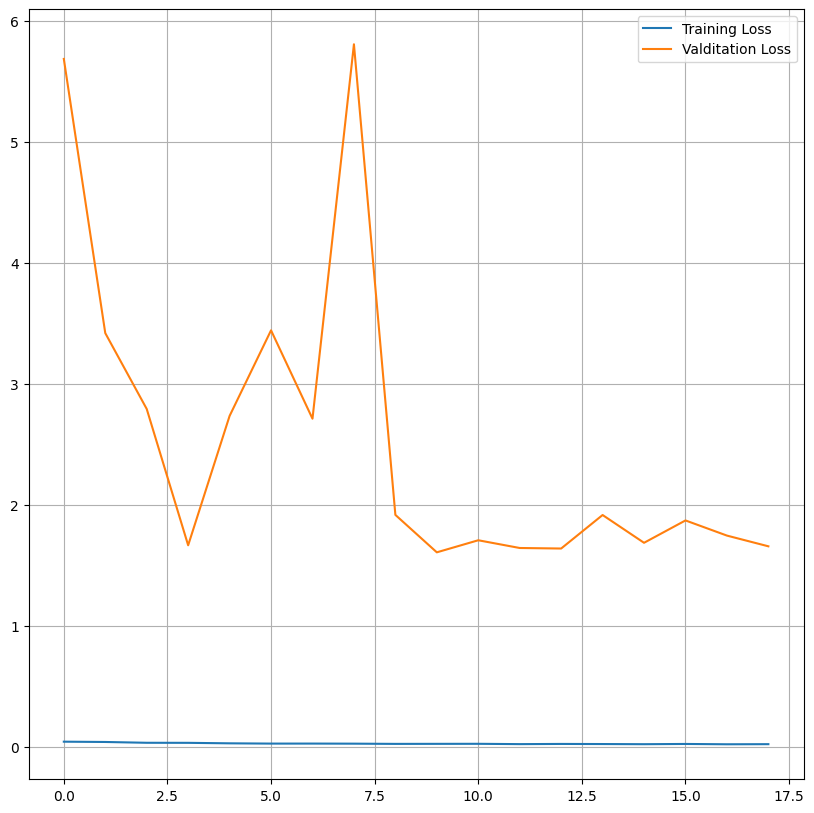

In [26]:
plt.figure(figsize=(10, 10))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Valditation Loss')

plt.grid(True)
plt.legend()
plt.show()

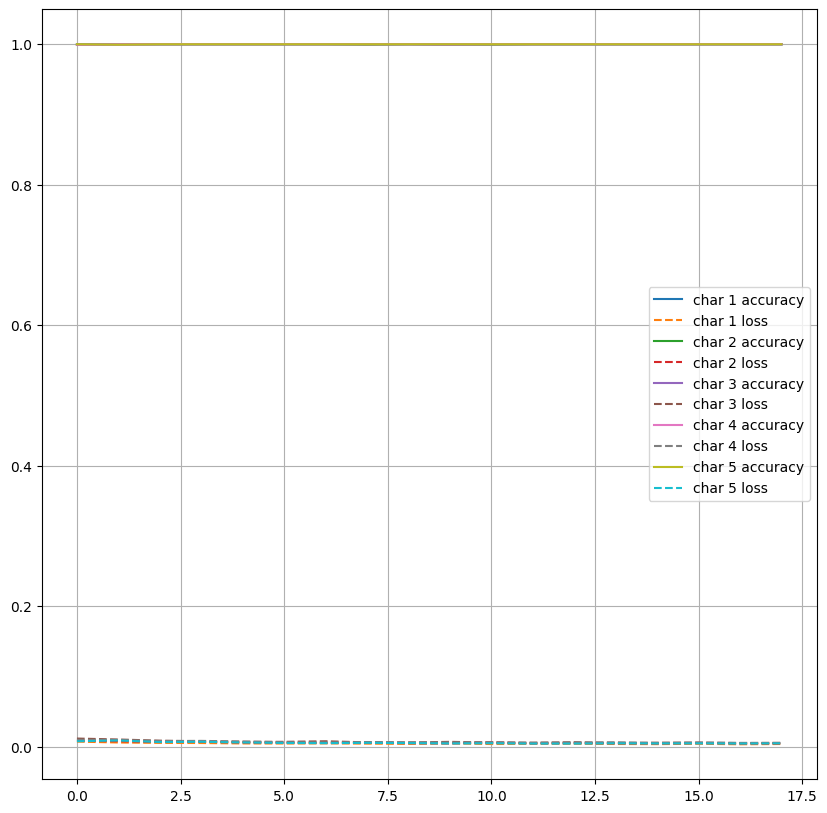

In [29]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.plot(history.history[f'char_{i+1}_accuracy'], label=f"char {i+1} accuracy")
    plt.plot(history.history[f'char_{i+1}_loss'], '--', label=f"char {i+1} loss")

plt.grid(True)
plt.legend()
plt.show()

In [30]:
result = model.evaluate(test_dataset, steps=validation_steps)
print(result)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - char_1_accuracy: 0.9252 - char_1_loss: 0.1845 - char_2_accuracy: 0.9243 - char_2_loss: 0.1996 - char_3_accuracy: 0.8380 - char_3_loss: 0.5704 - char_4_accuracy: 0.8631 - char_4_loss: 0.5076 - char_5_accuracy: 0.9245 - char_5_loss: 0.2457 - loss: 1.7077
[1.6091949939727783, 0.15685540437698364, 0.21929332613945007, 0.5585041642189026, 0.4230574071407318, 0.25148463249206543, 0.932692289352417, 0.9230769276618958, 0.8461538553237915, 0.875, 0.9278846383094788]


In [ ]:
def visualize_multi_output_predictions(model, dataset, classes_name, num_samples=5):
    # گرفتن یک batch
    data_iter = iter(dataset)
    images, labels = next(data_iter)

    # پیش‌بینی مدل
    predictions = model.predict(images)

    # اگر لیست نبود (مدل فقط یک خروجی داشت)، لیستش کن
    if not isinstance(predictions, list):
        predictions = [predictions]

    pred_labels = [tf.argmax(p, axis=-1).numpy() for p in predictions]  # list of (batch_size,)
    true_labels = tf.argmax(labels, axis=-1).numpy()  # shape: (batch_size, 5)

    for i in range(num_samples):
        img = images[i].numpy().astype('uint8')

        # بازسازی string label
        true_str = ''.join([classes_name[idx] for idx in true_labels[i]])
        pred_str = ''.join([classes_name[p[i]] for p in pred_labels])

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"True: {true_str}\nPred: {pred_str}")
        plt.axis('off')
        plt.show()

In [ ]:
classes_name = [str(i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)]

visualize_multi_output_predictions(model, test_dataset, classes_name=classes_name, num_samples=5)
